# Djikstra Mining Algorithm
## Problem Statement

A ship has a start position at time t=0, which we will call Point P. It must deliver its cargo to a shipyard at time t=t_max. What moves should it take that will deposit the maximum halite to a shipyard?

## Algorithm
Djikstra's algorithm is similar to a breadth-first search that can bail out of subsolutions that are clearly not optimal. It exploits a few features of our solution space. Namely that the best path from point P to point Q that goes through R MUST include the best path from R to Q. This allows us to find the best path between all neighbors of known best solutions.

A* would be lovely to use, but we don't have any way of knowing which actions will lead us toward the best solution so Djikstra's is the next best thing.

Another thing that can make Djiktra's particularly efficient is if we can quickly score a neighboring solution to a solution with a known score. We use the fact that adding movement to a solution doesn't change the score. So most of the neighboring solutions don't even need to be scored again.

## Description

We start out by assigning empty solutions for our destinations at t=0 

Every iteration we look at the best solution we found for our neighbors for t-1 as well as our current solution with an additional action of mining. One of those 5 solutions is the best solution for this position at t.

This algorithm should work fine for multiple destinations, but will only work fine for multiple start positions if you are lucky enough that all routes you find don't share any mining destinations or occupy the same position at the same time.

This is guaranteed to find the best mining route for one ship but is NOT guaranteed to find the global maximum for all ships. Which is probably acceptable. Simultaneously finding routes for all ships is possible but a little complicated to write.

## Variants

### Forward Solving
This approach solves for the solution from the destination to the source which is a little backwards, but it means that each solution is valid if a hypothetical ship was at that location. Instead you could solve it forwards meaning that the solution is valid if a hypothetical destination was at that location.

### Sparse Matrix
Right now we consider this a dense matrix meaning that potentially all squares are minable, but it may be that this could be considered a sparse matrix and it only makes sense to mine on a small number of cells. In that case, we'd want to represent it as a graph instead of a lattice. Solutions would be much more compact because intermediate destinations in between mining locations are irrelevant. I think it would be more complicated to write but it may turn out to be more efficient.
 
## Extensions
Right now we take the first, highest scoring path we find. Instead we could collect all high scoring paths we find. This would give us a collection of equivalent scoring paths to choose based on other criteria (ship congestion, hazards, etc). This wouldn't add to the runtime complexity. Just extra bookkeeping.

This cell just sets up the initial board so we have an interesting problem to look at.

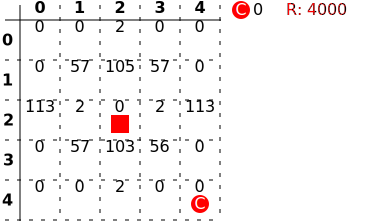

In [154]:
from kaggle_environments import make
from kaggle_environments.envs.halite.helpers import *
from board_viz import draw_board
board_size = 5
environment = make("halite", configuration={"size": board_size, "startingHalite": 1000})
agent_count = 1
environment.reset(agent_count)
state = environment.state[0]
board = Board(state.observation, environment.configuration)
s = list(board.ships.values())[0]
s.next_action = ShipAction.CONVERT
board = board.next()
sy = list(board.shipyards.values())[0]
sy.next_action = ShipyardAction.SPAWN
board = board.next()
s = list(board.ships.values())[0]
s.next_action = ShipAction.NORTH
board = board.next()
s = list(board.ships.values())[0]
s.next_action = ShipAction.EAST
board = board.next()
s = list(board.ships.values())[0]
s.next_action = ShipAction.EAST
board = board.next()
s = list(board.ships.values())[0]
s.next_action = ShipAction.NORTH
board = board.next()

draw_board(board)

Now we use this board to calculate the best routes for every square on the board up to 15 turns away.

In [155]:
from dataclasses import dataclass

# action names
NORTH = 'N'
SOUTH = 'S'
EAST = 'E'
WEST = 'W'
MINE = 'M'

# actions and where they come from
possible_actions = [
    (Point(1, 0), WEST),
    (Point(-1, 0), EAST), 
    # North and south are backward
    (Point(0, 1), SOUTH), 
    (Point(0, -1), NORTH), 
    (Point(0,0), MINE)]

@dataclass
class Route:
    # path is a str of concatenated action names
    path: str
    # expected amount of halite gained from this route
    value: int

# where an action would take you
dir_lookup = {
    EAST: Point(1, 0),
    WEST: Point(-1, 0),
    # north and south are backward
    NORTH: Point(0,1),
    SOUTH: Point(0,-1)
}

def score_path(path: str, start_point: Point):
    ''' find the expected score from path
    path is a str of concatenated action names
    TODO: Use the score of path[1:] to solve for the score of path
    '''
    halite = {point:cell.halite for point, cell in board.cells.items()}
    final_score = 0
    curr_pos = start_point
    for action in path:
        if action == MINE:
            final_score += halite[curr_pos]*0.25
            halite[curr_pos] *= 0.75
        else:
            curr_pos = (curr_pos+dir_lookup[action]) % board_size
    return final_score

t_max = 15

# TODO: Convert to numpy matrices
# m is a matrix of starting point to best route to a dest
m = [[None for x in range(board_size)] for y in range(board_size)]
# in this example 2,2 is the only dest
m[2][2] = Route('', 0)

m_next = [[None for x in range(board_size)] for y in range(board_size)]
for t in range(1, t_max+1):
    print('------')
    print(f't = {t}')
    for y in range(board_size):
        for x in range(board_size):
            # if there was a viable path to a dest from [y][x] for t[i-1]
            if m[y][x] is not None:
                me = m[y][x]
                # then there must be a viable path to all of my neighbors for t[i]
                for n in possible_actions:
                    p = (Point(x, y) + n[0]) % board_size
                    # The expected score to go from (x, y) to p
                    p_score = score_path(n[1] + me.path, p) if n[1] == MINE else me.value
                    # we have found the first path for p or we have found a better path for p
                    if m_next[p.y][p.x] is None or p_score > m_next[p.y][p.x].value:
                       m_next[p.y][p.x] = Route(n[1] + me.path, p_score)
    for row in m_next:
        print([s.path if s is not None else ' '*t for s in row])
    m = m_next
    m_next = [[None for x in range(board_size)] for y in range(board_size)]

------
t = 1
[' ', ' ', ' ', ' ', ' ']
[' ', ' ', 'N', ' ', ' ']
[' ', 'E', 'M', 'W', ' ']
[' ', ' ', 'S', ' ', ' ']
[' ', ' ', ' ', ' ', ' ']
------
t = 2
['  ', '  ', 'NN', '  ', '  ']
['  ', 'EN', 'MN', 'WN', '  ']
['EE', 'ME', 'SN', 'MW', 'WW']
['  ', 'SE', 'MS', 'SW', '  ']
['  ', '  ', 'SS', '  ', '  ']
------
t = 3
['   ', 'ENN', 'NMN', 'WNN', '   ']
['EEN', 'EMN', 'MMN', 'WMN', 'WWN']
['MEE', 'MME', 'SMN', 'MMW', 'MWW']
['SEE', 'EMS', 'MMS', 'WMS', 'SWW']
['   ', 'SSE', 'SMS', 'SSW', '   ']
------
t = 4
['EENN', 'ENMN', 'NMMN', 'WNMN', 'WWNN']
['NMEE', 'EMMN', 'MMMN', 'WMMN', 'NMWW']
['MMEE', 'WMEE', 'SMMN', 'EMWW', 'MMWW']
['SMEE', 'EMMS', 'MMMS', 'WMMS', 'SMWW']
['SSEE', 'SEMS', 'SMMS', 'SWMS', 'SSWW']
------
t = 5
['NNMEE', 'ENMMN', 'NMMMN', 'WNMMN', 'NNMWW']
['NMMEE', 'EMMMN', 'MMMMN', 'WMMMN', 'NMMWW']
['MMMEE', 'WMMEE', 'SMMMN', 'EMMWW', 'MMMWW']
['SMMEE', 'EMMMS', 'MMMMS', 'WMMMS', 'SMMWW']
['SSMEE', 'SEMMS', 'SMMMS', 'SWMMS', 'SSMWW']
------
t = 6
['NNMMEE', 'ENMMMN', '

In [156]:
friendly_names = {
    'N': 'North',
    'S': 'South',
    'E': 'East',
    'W': 'West'
}
ship_pos = list(board.ships.values())[0].position
print('start pos:', ship_pos, 'destination: (2, 2)')
route = m[ship_pos.y][ship_pos.x]
curr_pos = ship_pos
for p in route.path:
    if p == MINE:
        print('Mine')
        continue
    curr_pos = (dir_lookup[p]+curr_pos)%board_size
    print(f'head {friendly_names[p]} to {curr_pos}')
print('expected halite:', route.value)

start pos: (4, 4) destination: (2, 2)
head South to (4, 3)
head West to (3, 3)
Mine
head West to (2, 3)
Mine
Mine
head West to (1, 3)
Mine
Mine
Mine
head East to (2, 3)
Mine
Mine
Mine
head South to (2, 2)
expected halite: 125.5929951171875
